In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from natsort import natsorted

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Time points

In [3]:
#####Change to class?

#artifacts
first_art_begin = 0.081 
first_art_end = 0.0845 
second_art_begin = 0.131
second_art_end = 0.134

#time points of traces for analysis
end_cap = 0.02
first_stim_begin = 0.08
first_stim_end = 0.125
second_stim_begin = 0.136
second_stim_end = 0.175

#time points for finding NMDA decay time
end_tau_trace = 0.58
begin_NMDA_tau = 0.115
end_NMDA_tau = 0.5

#for finding tau of capacitance traces
begin_cap_curve = 0.00565
end_cap_curve = 0.011
begin_cap_baseline = 0.010
tau_threshold = 0.001

# Load experimental files and information

In [4]:
###Loop over all files in a folder to run automatically

#load excel file
wave_info = pd.read_excel('2016.10.26_Cell1.xlsx')
wave_info.head()

,waveNum,waveName,stimInt,notes
0,1,w7,40.0,noBic
1,2,w8,40.0,noBic
2,3,w9,40.0,noBic
3,4,w10,40.0,noBic
4,5,w11,40.0,noBic


In [5]:
#cell information
date = '2016.10.26'
cell_num = 1
age = 15

#Load csv
igor = pd.read_csv('igorForPython.csv', index_col = 0)

def select_waves(df):
    '''Takes the data frame of raw igor traces and: 
    1) indexes waves by wave names (info from excel file)
    2) removes traces with NaN values'''
    igor_waves = df.pivot(index='sec', columns='id', values='pA')
    waves = igor_waves.filter(wave_info['waveName'])
    waves = waves.dropna(axis = 0)
    return waves

#Reformat and select waves in waveInfo
all_waves = select_waves(igor)
all_waves.head()

id,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,...,w75,w76,w77,w78,w79,w80,w81,w82,w83,w84
sec,,,,,,,,,,,,,,,,,,,,,
0.00000,0.948830,-3.059967,1.289867,-1.231331,-0.434429,2.303024,1.274933,0.613708,0.796894,1.317093,...,4.723364,1.359512,-1.399342,1.061974,1.475237,2.330578,-3.692544,-1.730488,-1.836338,-1.835079
0.00002,0.323860,-3.059967,-0.897526,-0.606361,-1.684368,2.615509,0.024994,0.301224,2.671803,2.567032,...,4.098394,1.359512,-1.711826,2.624397,0.850267,2.018093,-3.067575,-0.793034,-2.461308,-1.522594
0.00004,0.323860,-2.434998,0.039928,-0.293877,-1.996853,1.053085,0.649963,-0.636230,2.359318,2.567032,...,3.785910,1.359512,-1.711826,2.624397,2.412691,2.018093,-3.692544,-2.355457,-1.836338,-1.522594
0.00006,0.948830,-2.747482,0.039928,0.956062,-0.746914,0.740601,0.962448,0.613708,1.421864,1.942062,...,4.098394,1.671997,-1.086857,1.999428,0.850267,2.330578,-3.692544,-1.730488,-2.773792,-2.772533
0.00008,-0.301109,-1.185059,-1.210011,0.643578,-1.684368,2.303024,-0.287491,-0.011261,1.421864,3.504486,...,3.785910,1.047028,-1.711826,2.624397,1.162752,2.330578,-1.505151,-0.480549,-2.461308,-2.147564


# Capacitance decay
Identify and remove waves where the capacitance decay time is above a particular threshold

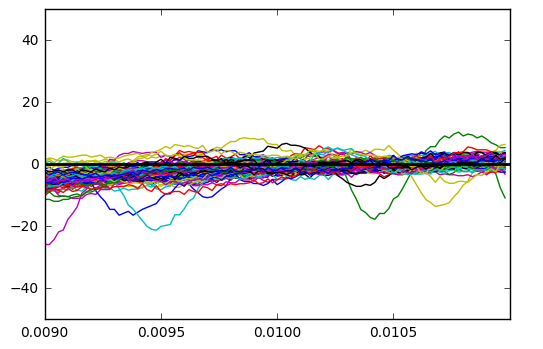

In [256]:
cap_curve = all_waves[begin_cap_curve:end_cap_curve]

#normalize each cap trace to zero
#normalized_cap = cap_curve - np.mean(cap_curve[begin_cap_baseline:end_cap_curve]) + 1.0e-10
normalized_cap = normalize_traces(cap_curve, begin_cap_baseline, end_cap_curve) + 1.0e-10

x = normalized_cap
fig, ax = plt.subplots()
ax.plot(x)
ax.axhline(y=0, color='k', linewidth=2)
ax.axvline(x=0, color='k')
ax.axis([begin_cap_curve, end_cap_curve, -350, 25])
plt.show();


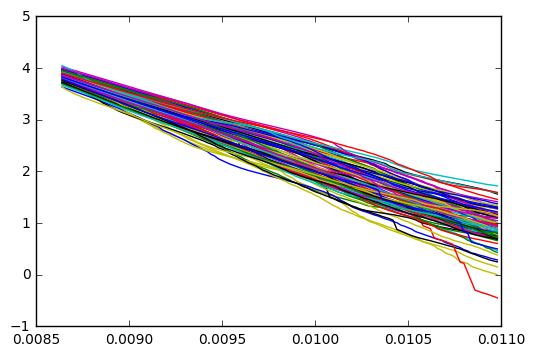

In [281]:
def smooth(df, window = 150):
    smoothed = df.rolling(window).mean()
    return smoothed

def log_to_fit(df, window = 150):
    log_curve = np.log(abs(df))
    smoothed_curve = smooth(log_curve, window)
    return log_curve, smoothed_curve

#Take log of amplitudes so can fit a linear model to cap traces
(_, smoothed_cap) = log_to_fit(normalized_cap)

plt.plot(smoothed_cap)
plt.show();


In [11]:
#Fit a linear model
traces_for_reg = smoothed_curve.reset_index()
reg_model = {}
for col_name in traces_for_reg.drop('sec', axis=1).columns:
    model = smf.ols(formula=col_name +' ~ sec', data=traces_for_reg)
    reg_model[col_name] = model.fit()

#Examine parameters of individual waves
#regModel['w7'].params

#Pull out coefficients of each trace
coefs = []
ids = []
for key in reg_model:
    id = key
    ids.append(id)
    coef = reg_model[key].params
    coefs.append(coef)

coefs = pd.DataFrame(coefs, index = natsorted(ids))
coefs.head()

#Calculate all capacitance taus (small tau = fast decay)
decay_times = abs(1 / coefs.drop('Intercept', 1))
decay_times = decay_times.rename(columns = {'sec':'capacitance tau'})
decay_times.head()


,Intercept,sec
w7,13.362069,-1108.782932
w8,13.846590,-1149.910730
w9,15.106549,-1310.363381
w10,14.528275,-1213.540703
w11,15.022190,-1272.741658


,capacitance tau
w7,0.000902
w8,0.000870
w9,0.000763
w10,0.000824
w11,0.000786


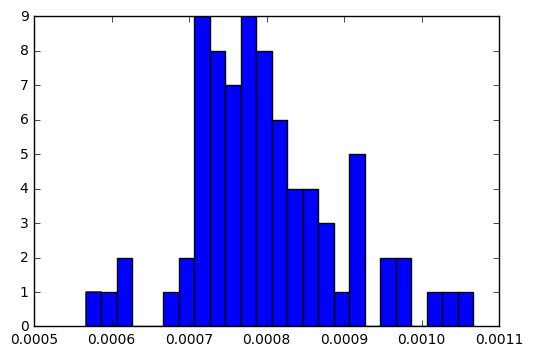

In [12]:
plt.hist(decay_times['capacitance tau'], bins = 25)
plt.show();


# What is the threshold for capacitance decay?
It is known that decreased capacitance implies increased resistance, which then decreases current flow. Therefore a slow capacitance decay time affects current responses of a neuron, decreasing current amplitudes at a fixed stimulation intensity compared to a faster decay time. The question is then, what is the threshold for capacitance decay times where the slow decay begins affecting the current amplitude?

In [13]:
#Plot cap decay times vs. amplitude vs. stimInt; what is the corr bw cap decay time and amplitude
#In other words how slow is too slow?
max_amplitudes = pd.DataFrame(abs(all_waves.max()), columns = ['maximals'])
stim_int = wave_info.drop(wave_info.columns[[0, 3]], axis = 1)
stim_int = stim_int.set_index('waveName')
stim_int.columns = ['stimulus intensity']
cap_vs_max = pd.concat([decay_times, max_amplitudes, stim_int], axis = 1)
cap_vs_max['log stimulus intensity'] = cap_vs_max['stimulus intensity'].apply(np.log)
cap_vs_max.head()

,capacitance tau,maximals,stimulus intensity,log stimulus intensity
w7,0.000902,486.550110,40.0,3.688879
w8,0.000870,1786.540161,40.0,3.688879
w9,0.000763,572.511963,40.0,3.688879
w10,0.000824,1872.427246,40.0,3.688879
w11,0.000786,565.787903,40.0,3.688879


In [14]:
cap_vs_max_A = cap_vs_max[::2]
cap_vs_max_N = cap_vs_max[1::2]

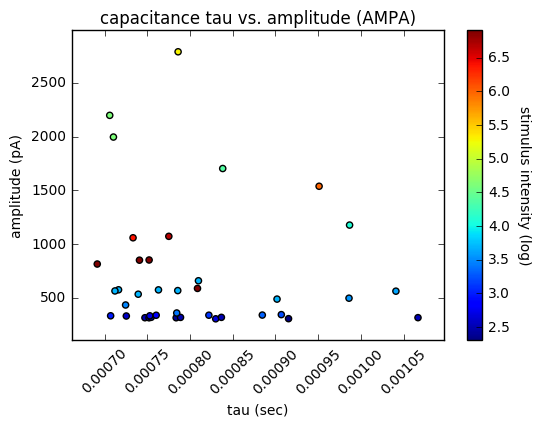

In [15]:
to_plot = cap_vs_max_A
x_margins = 3.0e-5
y_margins = 200
plt.scatter(to_plot['capacitance tau'], to_plot['maximals'], c = to_plot['log stimulus intensity'])
plt.axis([to_plot['capacitance tau'].min() - x_margins, to_plot['capacitance tau'].max() + x_margins, 
          to_plot['maximals'].min() - y_margins, to_plot['maximals'].max() + y_margins])
plt.title('capacitance tau vs. amplitude (AMPA)')
plt.xlabel('tau (sec)')
plt.ylabel('amplitude (pA)')
plt.xticks(rotation=45)
clb = plt.colorbar()
clb.ax.get_yaxis().labelpad = 15
clb.ax.set_ylabel('stimulus intensity (log)', rotation = 270)
plt.show();

In [387]:
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.models import LogColorMapper, LogTicker, ColorBar, HoverTool
from bokeh.layouts import row

def plot_cap_max(df, title):
    source = ColumnDataSource(df)
    p = figure(x_axis_label = 'tau (sec)', y_axis_label = 'amplitude (pA)', \
               title = title + ' amplitude vs. capacitance decay')

    color_mapper = LogColorMapper(palette = 'Viridis256', low = 10, high = 1000)
    
    p.circle(x = 'capacitance tau', y = 'maximals', source = source, \
              color = dict(field = 'stimulus intensity', transform = color_mapper), size = 4.5)
    
    color_bar = ColorBar(color_mapper = color_mapper, ticker = LogTicker(),\
                         label_standoff = 8, border_line_color = None, location = (0,0))
    p.add_layout(color_bar, 'right')
    
    hover = HoverTool(tooltips = [
            ('ID', '@index'),
            ('Tau', '@{capacitance tau}'),
            ('Amplitude', '@maximals'),
            ('Stimulus intensity', '@{stimulus intensity}')
        ])
    
    p.add_tools(hover)
    
    return p

p1 = plot_cap_max(cap_vs_max_A, 'AMPA')
p2 = plot_cap_max(cap_vs_max_N, 'NMDA')

layout = row(p1, p2)

output_notebook();
show(layout);

Loading BokehJS ...

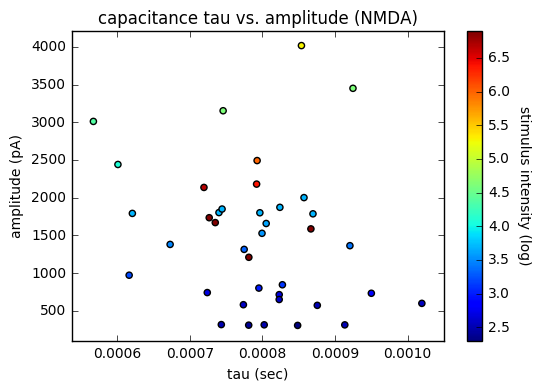

In [16]:
to_plot = cap_vs_max_N
x_margins = 3.0e-5
y_margins = 200
plt.scatter(to_plot['capacitance tau'], to_plot['maximals'], c = to_plot['log stimulus intensity'])
plt.axis([to_plot['capacitance tau'].min() - x_margins, to_plot['capacitance tau'].max() + x_margins, 
          to_plot['maximals'].min() - y_margins, to_plot['maximals'].max() + y_margins])
plt.title('capacitance tau vs. amplitude (NMDA)')
plt.xlabel('tau (sec)')
plt.ylabel('amplitude (pA)')
clb = plt.colorbar()
clb.ax.get_yaxis().labelpad = 15
clb.ax.set_ylabel('stimulus intensity (log)', rotation = 270)
plt.show();

## CIRCLE POINTS WITH SAME STIM INT

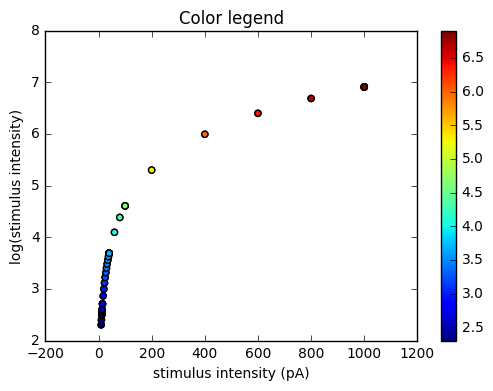

In [17]:
plt.scatter(cap_vs_max['stimulus intensity'], cap_vs_max['log stimulus intensity'], 
            c = cap_vs_max['log stimulus intensity'])
plt.colorbar()
plt.title('Color legend')
plt.xlabel('stimulus intensity (pA)')
plt.ylabel('log(stimulus intensity)')
plt.show();

In addition to decreasing current amplitudes, another concern regarding large capacitance tau is it could lead to increased AMPA tau due to worsening access. Therefore, AMPA tau must also be calculated. To do so:
* Isolate AMPA waves following first stimulus
* Remove stimulus artifact
* Performing above step allows automatic identification of peak of AMPA trace
* Fit a curve from peak of AMPA trace to end of stimulation

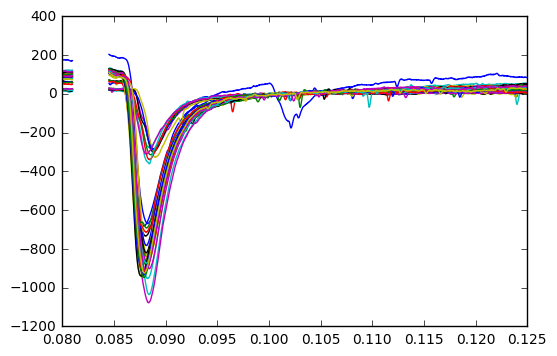

In [394]:
def normalize_traces(df, begin, end):
    '''Normalizes traces to baseline'''
    baseline = df[begin:end]
    baseline = baseline.dropna(axis = 0)
    avg_baseline = baseline.mean()
    normalized_traces = df.subtract(avg_baseline)
    return normalized_traces

def remove_artifact(df, begin, end):
    '''Removes stimulus artifact'''
    df[begin:end] = np.nan
    return df

#Prep AMPA traces to fit decay curve
#normalize AMPA traces to baseline, blank stimulus artifact
AMPA = all_waves[all_waves.columns[::2]]
normalized_AMPA = normalize_traces(AMPA, 0.096, 0.11)[first_stim_begin:first_stim_end]
normalized_AMPA = remove_artifact(normalized_AMPA, first_art_begin, first_art_end)

#remove traces traces at zero = failures
success_trace_index = normalized_AMPA.mean() <= -10 #if the mean of the trace is <= -10, trace is a failure
success_traces = normalized_AMPA[normalized_AMPA.columns[success_trace_index]]

plt.plot(success_traces)
plt.show();

In [395]:
success_traces.tail()

id,w7,w9,w11,w13,w15,w17,w19,w21,w23,w25,...,w65,w67,w69,w71,w73,w75,w77,w79,w81,w83
sec,,,,,,,,,,,,,,,,,,,,,
0.12492,32.605406,28.819474,37.710355,54.833717,51.379000,43.489763,50.899797,85.433605,40.482599,39.666394,...,30.988590,41.492714,31.838235,37.853002,29.184113,31.462889,38.382577,32.999459,38.079906,27.355565
0.12494,33.855345,28.194504,37.085386,54.521232,51.691484,43.489763,51.837251,85.746075,41.420053,40.291364,...,31.301075,41.492714,31.213266,36.915548,30.434052,30.837920,37.132638,32.686974,38.392391,25.793141
0.12496,31.980437,28.506989,37.710355,54.521232,52.941423,44.739702,50.587312,85.433605,42.045023,39.666394,...,30.988590,42.117683,31.525751,36.290578,29.496598,31.775374,37.757607,33.311943,39.329845,25.793141
0.12498,32.605406,29.444443,38.022840,54.208748,52.003969,44.427217,50.274828,84.183666,41.732538,40.603848,...,30.676105,41.805198,30.588296,37.540517,28.871629,32.087859,39.007546,32.062004,38.704876,27.355565
0.12500,32.917876,27.569535,36.772901,53.583778,52.316454,44.114732,51.212282,83.871166,42.045023,40.603848,...,30.676105,41.805198,31.213266,37.853002,29.809083,31.462889,38.382577,31.749520,37.767421,26.105626


In [396]:
p = figure(x_axis_label = 'seconds', y_axis_label = 'pA')
p.line(success_traces.index, success_traces['w7'])
output_notebook()
show(p);

Loading BokehJS ...

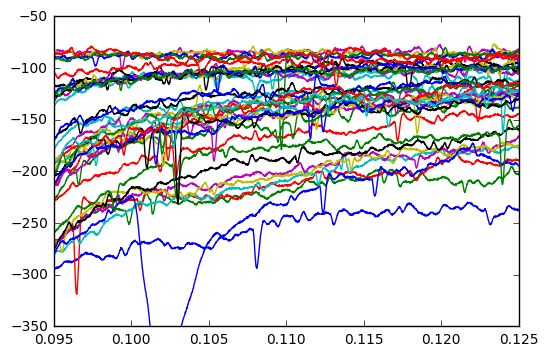

In [271]:
plt.plot(AMPA)
plt.axis([0.095, 0.125, -350, -50])
plt.show();

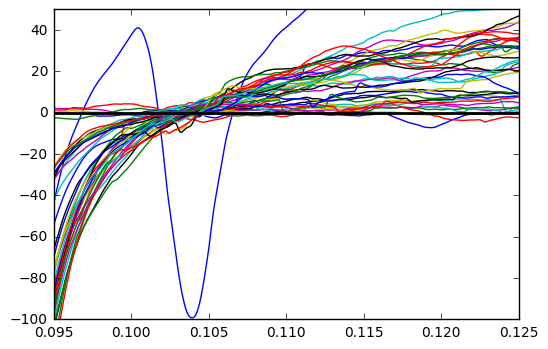

In [293]:
p = smooth(normalized_AMPA)
fig, ax = plt.subplots()
ax.plot(p)
ax.axhline(y=0, color='k', linewidth=2)
ax.axvline(x=0, color='k')
ax.axis([0.095, 0.125, -100, 50])
plt.show();

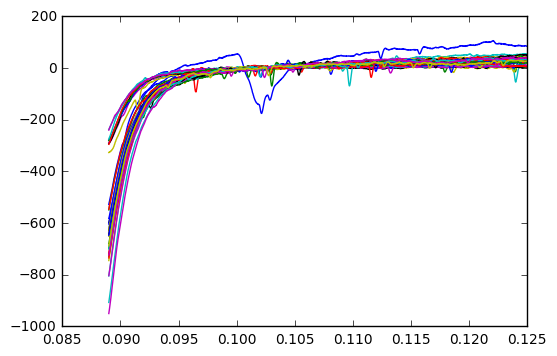

In [294]:
#suppresses error message
pd.options.mode.chained_assignment = None 

#align peak of AMPA trace
aligned_traces = success_traces
for c in aligned_traces.columns:
    min_index = success_traces.idxmin()
    aligned_traces.loc[aligned_traces[c].index < min_index[c]] = np.nan 

plt.plot(aligned_traces)
plt.show();

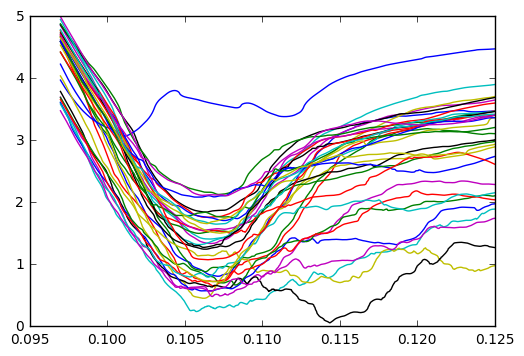

In [295]:
(_, smoothed_AMPA) = log_to_fit(aligned_traces, window = 400)
plt.plot(smoothed_AMPA)
plt.show();

Are features (capacitance tau, maximals, stimulus intensity, AMPA tau) correlated?

In [49]:
cap_vs_max_A.corr()

,capacitance tau,maximals,stimulus intensity,log stimulus intensity
capacitance tau,1.000000,-0.099523,-0.212015,-0.176852
maximals,-0.099523,1.000000,0.239122,0.539991
stimulus intensity,-0.212015,0.239122,1.000000,0.909945
log stimulus intensity,-0.176852,0.539991,0.909945,1.000000


In [ ]:
cap_vs_max_N.iloc[:, 3:].corr()

There seems to exist only weak overall correlation between capacitance tau and the other features. 
Use anomaly detection (kNN, random forest?) to detect rare event, i.e., an unsuitable trace. Assumption is that obviously unhealthy cells are discarded during recording and/or prior to analysis.

In [92]:
#scale data
from sklearn import preprocessing

def scale_columns(series):
    '''Uses sklearn's scale function to standardize all data in a df
    column (a pandas Series object) to zero mean and unit variance'''
    scaled = preprocessing.scale(np.array(series))
    return scaled

def recombine_AN(dfA, dfN):
    '''Recombines individual AMPA and NMDA dfs
    back into one df in an ordered manner'''
    _ = list(zip(dfA, dfN))
    recombined = [item for sublist in _ for item in sublist]
    return recombined

cap_vs_max['scaled cap tau'] = scale_columns(cap_vs_max['capacitance tau'])
scaled_AMPA = scale_columns(cap_vs_max.maximals[::2])
scaled_NMDA = scale_columns(cap_vs_max.maximals[1::2])
cap_vs_max['scaled maximals'] = recombine_AN(scaled_AMPA, scaled_NMDA)

cap_vs_max.head()

,capacitance tau,maximals,stimulus intensity,log stimulus intensity,scaled cap tau,scaled maximals
w7,0.000902,486.550110,40.0,3.688879,1.075949,-0.378496
w8,0.000870,1786.540161,40.0,3.688879,0.738305,0.328555
w9,0.000763,572.511963,40.0,3.688879,-0.376312,-0.230889
w10,0.000824,1872.427246,40.0,3.688879,0.261020,0.423017
w11,0.000786,565.787903,40.0,3.688879,-0.140188,-0.242435


In [ ]:
#from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(capVSmax['capTauScaled'], capVSmax['maxScaled'], capVSmax['logStimInt']);
#plt.show();

# Removing unhealthy waves 

Unhealthy waves (or waves unsuitable for analysis) must be removed prior to calculations. For analysis AMPA and NMDA waves must be paired, i.e., an AMPA trace must have a matched NMDA trace and vice versa. 

Therefore, to remove unhealthy waves and their corresponding partners:
* Identify unhealthy waves by capacitance decay time, AMPA decay and leak currents
* Split waves into AMPA and NMDA waves
* Remove unhealthy waves by index in individual AMPA/NMDA dfs (indices are the same in the individual dfs)
* Create a list of ids of healthy cells and filter allWaves on list

In [93]:
#list below for test purposes only; should be identified automatically
unhealthy = [1,3,5,7]

def remove_unhealthy(df, unhealthyIndices):    
    '''Removes unsuitable/unhealthy traces by index'''
    AMPA = df[df.columns[::2]]
    NMDA = df[df.columns[1::2]]
    healthy_A = AMPA.drop(AMPA.columns[unhealthyIndices], axis = 1)
    healthy_N = NMDA.drop(NMDA.columns[unhealthyIndices], axis = 1)
    healthy_waves = df.filter(recombine_AN(healthy_A, healthy_N))
    return healthy_waves

healthy_waves = remove_unhealthy(all_waves, unhealthy)
healthy_waves.head()

id,w7,w8,w11,w12,w15,w16,w19,w20,w23,w24,...,w75,w76,w77,w78,w79,w80,w81,w82,w83,w84
sec,,,,,,,,,,,,,,,,,,,,,
0.00000,0.948830,-3.059967,-0.434429,2.303024,0.796894,1.317093,-1.508808,-2.741348,1.437916,-16.500637,...,4.723364,1.359512,-1.399342,1.061974,1.475237,2.330578,-3.692544,-1.730488,-1.836338,-1.835079
0.00002,0.323860,-3.059967,-1.684368,2.615509,2.671803,2.567032,-1.508808,-3.991287,1.125431,-16.813122,...,4.098394,1.359512,-1.711826,2.624397,0.850267,2.018093,-3.067575,-0.793034,-2.461308,-1.522594
0.00004,0.323860,-2.434998,-1.996853,1.053085,2.359318,2.567032,-2.446262,-2.116379,0.500462,-14.938213,...,3.785910,1.359512,-1.711826,2.624397,2.412691,2.018093,-3.692544,-2.355457,-1.836338,-1.522594
0.00006,0.948830,-2.747482,-0.746914,0.740601,1.421864,1.942062,-2.446262,-3.366318,1.125431,-14.000759,...,4.098394,1.671997,-1.086857,1.999428,0.850267,2.330578,-3.692544,-1.730488,-2.773792,-2.772533
0.00008,-0.301109,-1.185059,-1.684368,2.303024,1.421864,3.504486,-3.383717,-3.678802,1.125431,-12.438335,...,3.785910,1.047028,-1.711826,2.624397,1.162752,2.330578,-1.505151,-0.480549,-2.461308,-2.147564


# Process waves
* Remove stimulus artifacts
* Normalize traces
* Split waves into sections for analysis